In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
from importlib import reload
from scipy import interpolate
import PIVutils
import PODutils

from sklearn.manifold import LocallyLinearEmbedding
from time import time
#from scipy import interpolate.interp2d

saveFolder = '/Users/Owen/Dropbox/Python Codes/ASIIT/Data/'
saveFile = 'RNV45-thumbs.hdf5'
imgFolder = saveFolder[:-5] + 'RNV45-LLEthumbs'

OriginalDataset = '/Users/Owen/Dropbox/Data/ABL/SBL PIV data/RNV45-RI2.mat'

import os
if not os.path.exists(saveFolder):
    os.makedirs(saveFolder)

In [2]:
X,Y,x,y,U,V,S,missVecs_Pro,Yind_Pro,Ypos_Pro,Ur,Vr,Sr,missVecs_Ret,Yind_Ret,Ypos_Ret,Yvec,Cond,Prof,ThumbParams = \
                        PIVutils.loadDataset(saveFolder + saveFile,
                         ['X','Y','x','y','U','V','S','missVecs','Yind_Pro','Ypos_Pro','Ur','Vr','Sr','missVecs_Ret','Yind_Ret','Ypos_Ret','Yvec'], 
                         ['Cond','Prof','ThumbParams'])
BoxSize = ThumbParams['BoxSize']
uSize = U.shape

['Cond', 'Prof', 'S', 'Sr', 'ThumbParams', 'U', 'Ur', 'V', 'Vr', 'X', 'Y', 'Yind_Pro', 'Yind_Ret', 'Ypos_Pro', 'Ypos_Ret', 'Yvec', 'missVecs', 'missVecs_Ret', 'x', 'y']


# Subtract mean profile

In [3]:
#Calculate mean velocity profiles
Umean = Prof['U']

#Now get the thumbnails
thumb = 0
for i in range(uSize[2]):
    ind = Yind_Pro[i]
    #U[:,:,thumb] = U[:,:,thumb]-np.transpose(np.tile(Umean[ind-BoxSize:ind+BoxSize+1],(1,uSize[0])),(1,0))
    U[:,:,thumb] = U[:,:,thumb]-np.tile(Umean[ind-BoxSize:ind+BoxSize+1],(1,uSize[0]))#Now get the thumbnails
    thumb+=1
#del Umean


/Users/Owen/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Now do a range of different manifold learning on the resulting thumbnails

In [4]:
#Set all NaNs to zero
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

uSize = U.shape

In [5]:
ncomp = 4
nneigh = 100

In [6]:
uAll = np.concatenate((U.reshape(uSize[0]*uSize[1],uSize[2]), V.reshape(uSize[0]*uSize[1],uSize[2])), axis = 0).T
#uAll.shape      

##### Do regular LLE

In [7]:
t0 = time()
model = LocallyLinearEmbedding(n_neighbors=nneigh, n_components=ncomp, eigen_solver='dense')
#outLLE = model.fit_transform(Ut.reshape(uSize[0]*uSize[1],uSize[2]).T)
outLLE = model.fit_transform(uAll)
print((time() - t0)/60, " mins")

5.430935966968536  mins


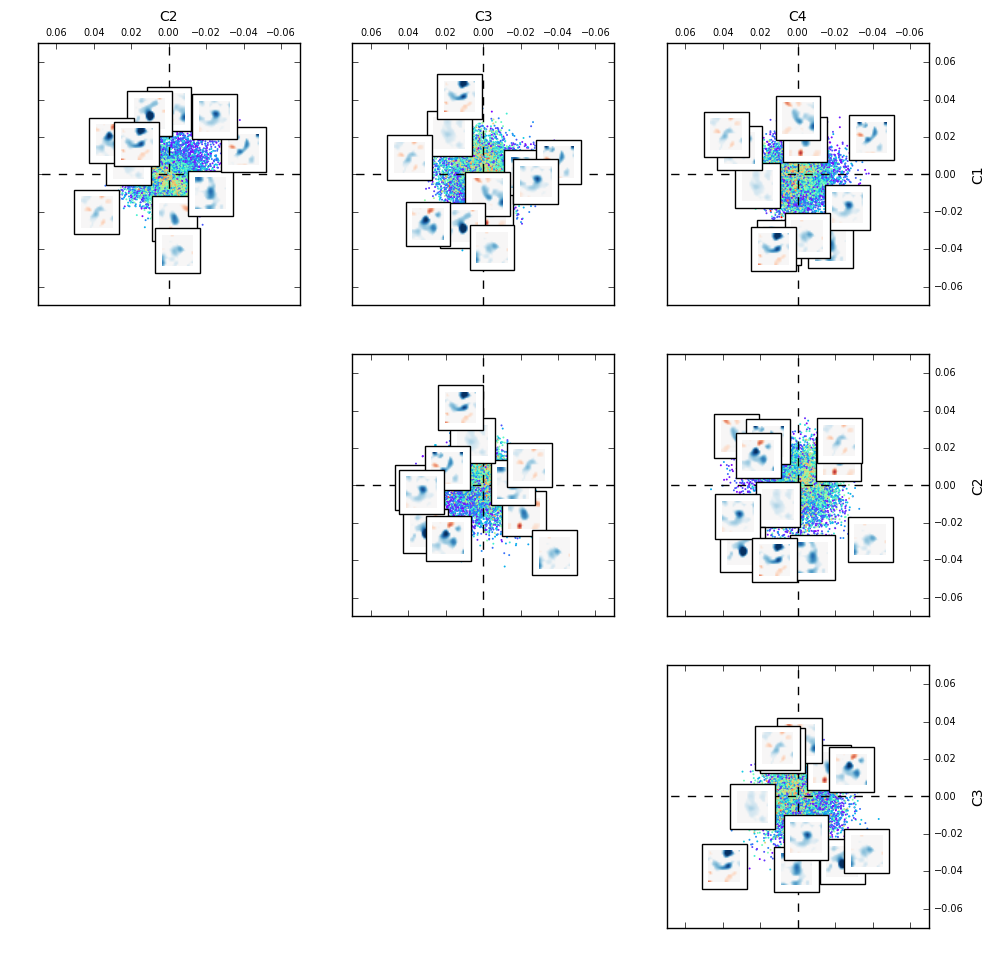

In [8]:
reload(PODutils)
PODutils.plotLLEscatter(outLLE.T,Ypos_Pro,S,list(range(ncomp)),bound=0.07,thumb_frac=0.4,VecDist=0.01)

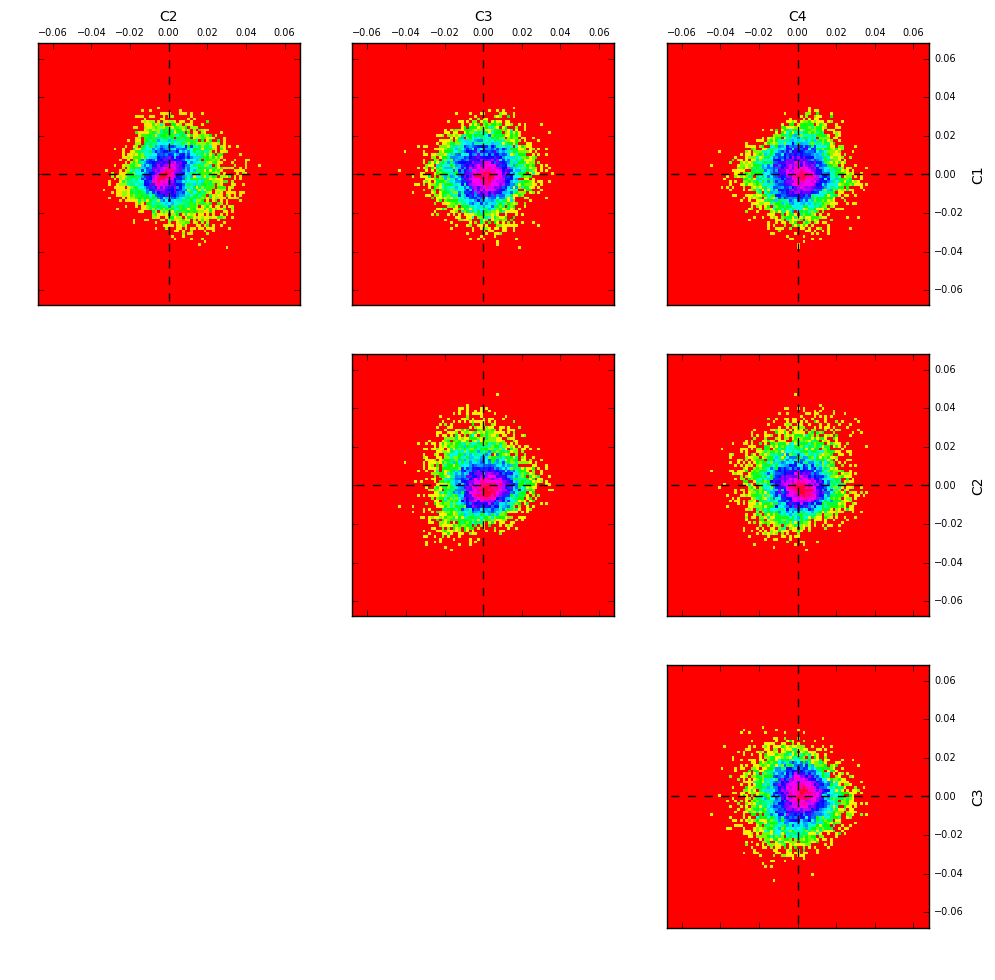

In [9]:
reload(PODutils)
PODutils.plotPODcoeff(outLLE.T,list(range(ncomp)),100,0.07,1)

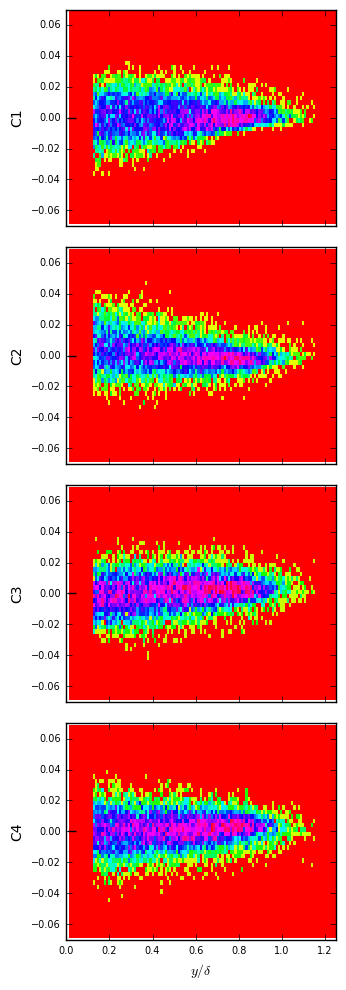

In [10]:
reload(PODutils)
C2 = outLLE.copy()
C2 = np.concatenate([Ypos_Pro.reshape((-1, 1)).T, C2.T], axis=0)
PODutils.plotYposPODcoeff(Yvec,C2,list(range(ncomp)),50,0.07,1)

#### Do modified LLE

In [11]:
t0 = time()
model = LocallyLinearEmbedding(n_neighbors=nneigh, n_components=ncomp, method='modified', eigen_solver='dense')
#outLLEmod = model.fit_transform(Ut.reshape(uSize[0]*uSize[1],uSize[2]).T)
outLLEmod = model.fit_transform(uAll)
print((time() - t0)/60, " mins")

5.063352318604787  mins


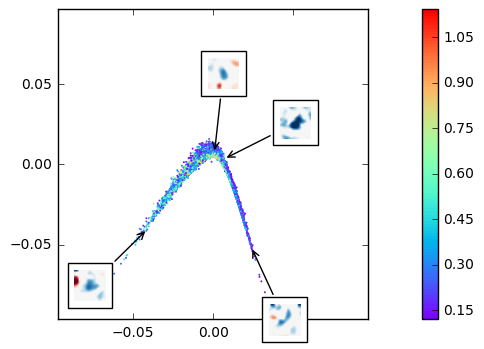

In [12]:
from matplotlib import offsetbox,colors

colorize = dict(c=Ypos_Pro, cmap=plt.cm.get_cmap('rainbow', 100))
fig, ax = plt.subplots()
h = ax.scatter(outLLEmod[:, 0], outLLEmod[:, 1],s=2, facecolor='0.5', lw = 0, **colorize)
fig.colorbar(h, ax=ax)
plt.axis('scaled')
bound = np.max(np.absolute(outLLEmod))
ax.set_xlim(-1*bound,bound)
ax.set_ylim(-1*bound,bound)

thumb_frac=0.4
cmap='RdBu_r'

min_dist_2 = (thumb_frac * max(outLLEmod.max(0) - outLLEmod.min(0))) ** 2
shown_images = np.array([2 * outLLEmod.max(0)])
for i in range(outLLEmod.shape[0]):
    dist = np.sum((outLLEmod[i] - shown_images) ** 2, 1)
    if np.min(dist) < min_dist_2:
        # don't show points that are too close
        continue
    shown_images = np.vstack([shown_images, outLLEmod[i]])
    
    vecNorm = (outLLEmod[i,0]**2 + outLLEmod[i,1]**2)**0.5
    imagebox = offsetbox.AnnotationBbox(
        offsetbox.OffsetImage(S[:,:,i], cmap=cmap, norm=colors.Normalize(-50,50),zoom=1.5),
                              xybox=0.05*outLLEmod[i,0:2]/vecNorm+outLLEmod[i,0:2],xy=outLLEmod[i,0:2], arrowprops=dict(arrowstyle="->"))
    ax.add_artist(imagebox)
    #imagebox.set_clim([-1*10, 10])

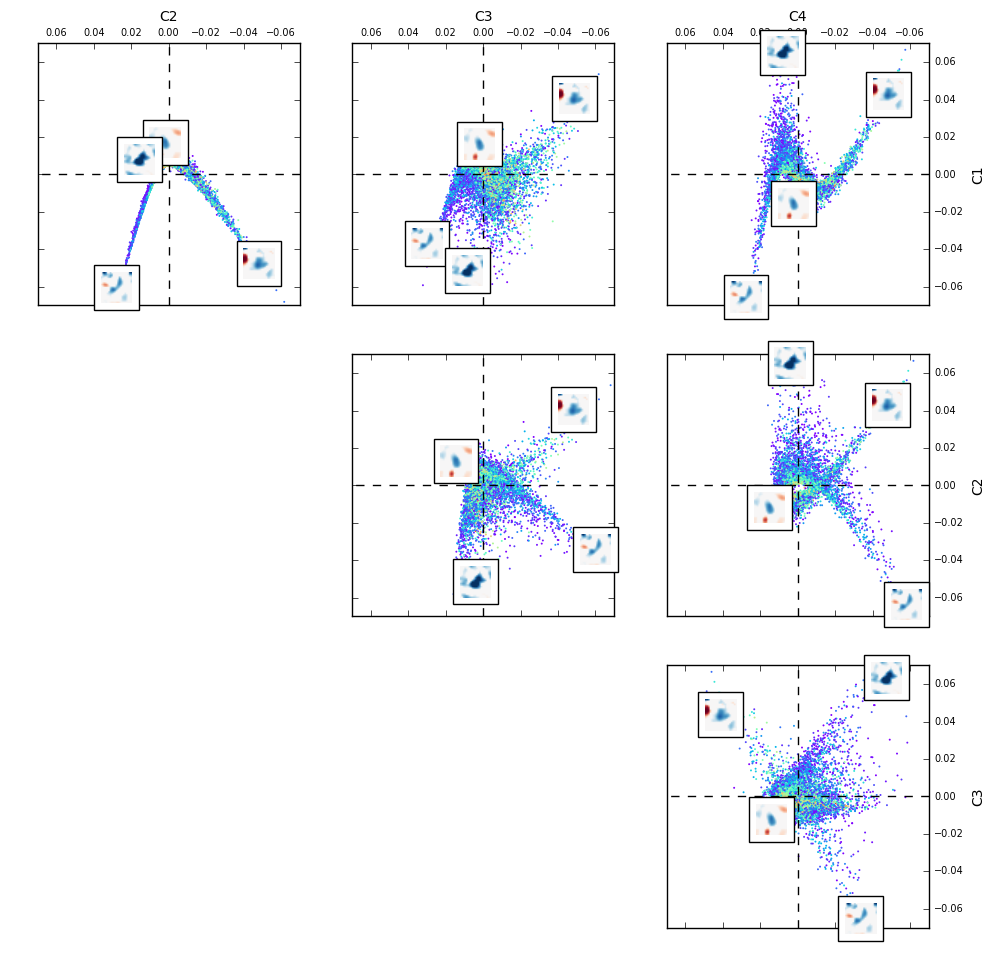

In [13]:
reload(PODutils)
PODutils.plotLLEscatter(outLLEmod.T,Ypos_Pro,S,list(range(ncomp)),bound=0.07,thumb_frac=0.4,VecDist=0.01,saveFolder=(saveFolder + '/LLEscatter_mod.tif'))

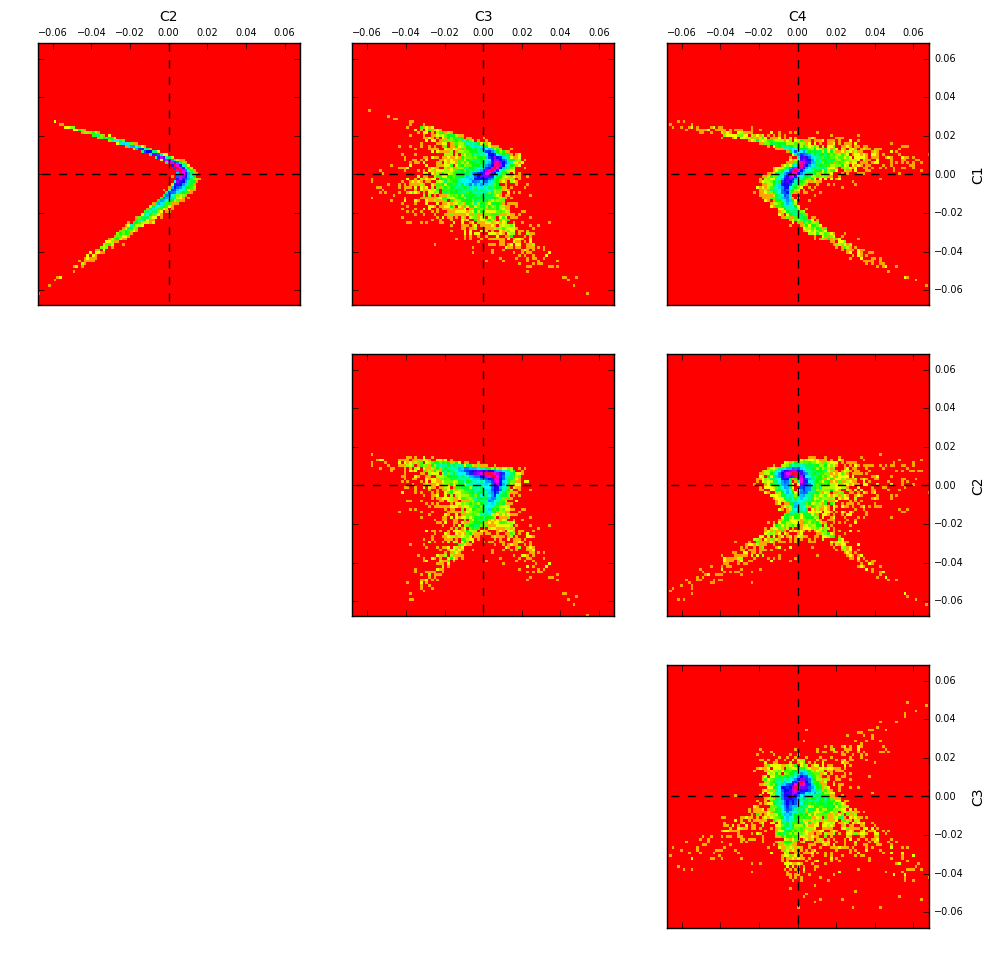

In [14]:
reload(PODutils)
PODutils.plotPODcoeff(outLLEmod.T,list(range(ncomp)),100,0.07,1,saveFolder=(saveFolder + '/Coeff_mod.tif'))

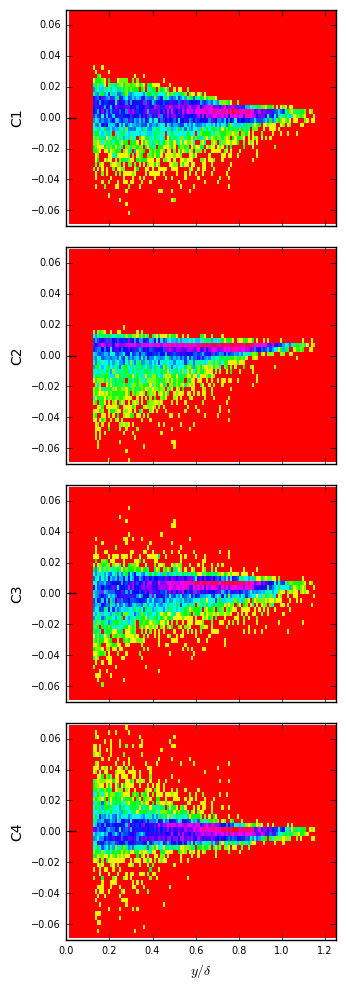

In [15]:
reload(PODutils)
C2 = outLLEmod.copy()
C2 = np.concatenate([Ypos_Pro.reshape((-1, 1)).T, C2.T], axis=0)
PODutils.plotYposPODcoeff(Yvec,C2,list(range(ncomp)),50,0.07,1,saveFolder=(saveFolder + '/YposCoeff_mod.tif'))

#### Do Hessian Eigenmaping LLE

In [16]:
t0 = time()
model = LocallyLinearEmbedding(n_neighbors=nneigh, n_components=ncomp, method='hessian', eigen_solver='dense')
#outLLE = model.fit_transform(Ut.reshape(uSize[0]*uSize[1],uSize[2]).T)
outLLEhes = model.fit_transform(uAll)
print((time() - t0)/60, " mins")

5.147338934739431  mins


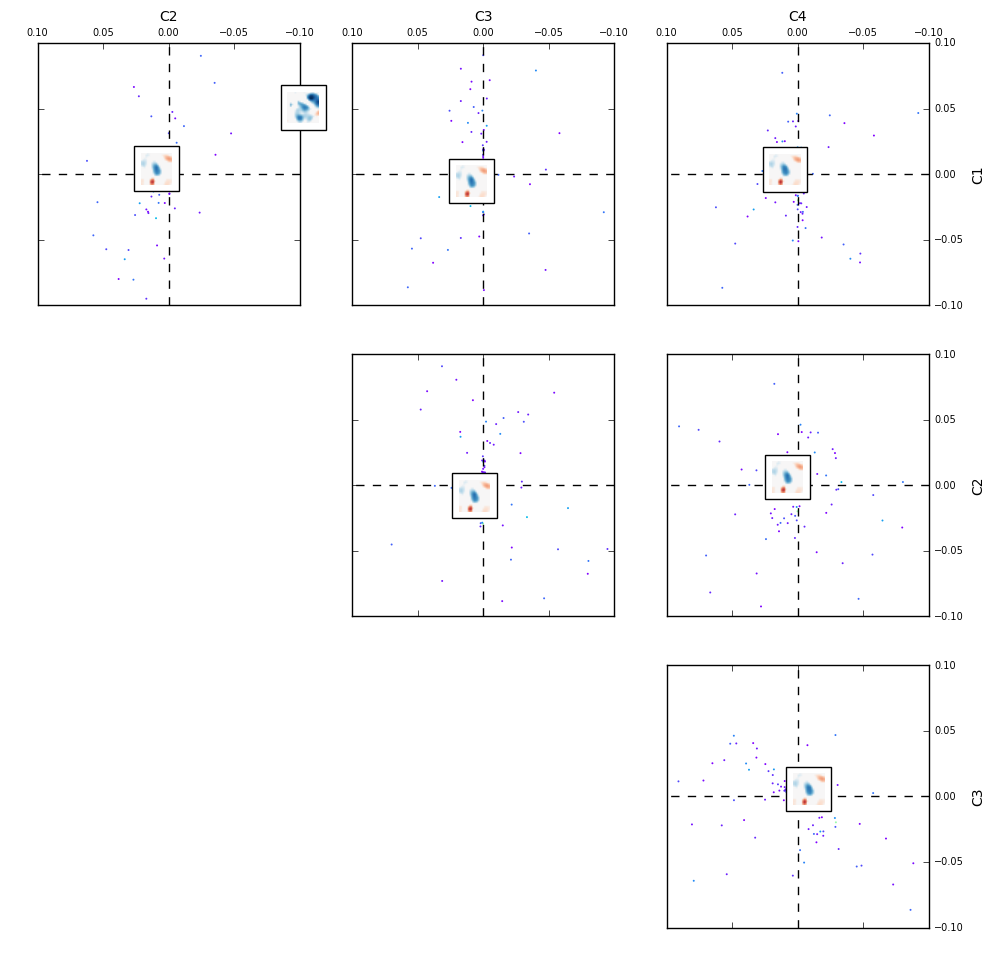

In [17]:
reload(PODutils)
PODutils.plotLLEscatter(outLLEhes.T,Ypos_Pro,S,list(range(ncomp)),bound=0.1,thumb_frac=0.4,VecDist=0.01)

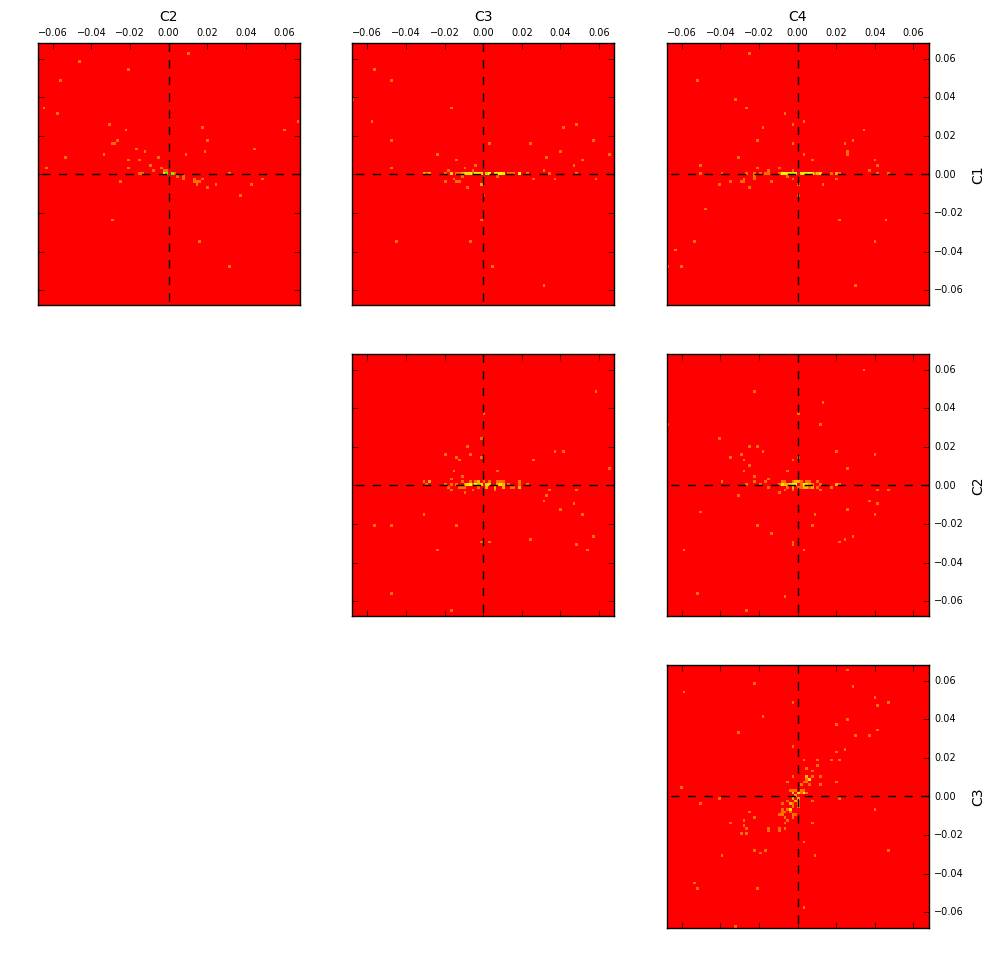

In [18]:
reload(PODutils)
PODutils.plotPODcoeff(outLLEhes.T,list(range(ncomp)),100,0.07,1)

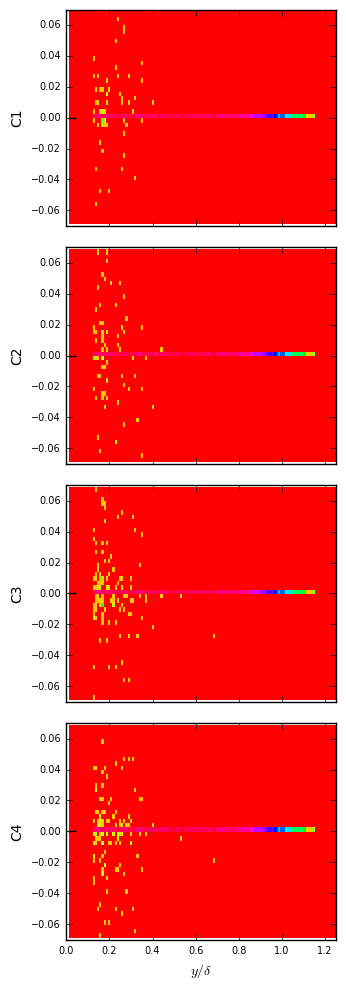

In [19]:
reload(PODutils)
C2 = outLLEhes.copy()
C2 = np.concatenate([Ypos_Pro.reshape((-1, 1)).T, C2.T], axis=0)
PODutils.plotYposPODcoeff(Yvec,C2,list(range(ncomp)),50,0.07,1)

#### Do LTSA LLE

In [20]:
t0 = time()
model = LocallyLinearEmbedding(n_neighbors=nneigh, n_components=ncomp,method='ltsa', eigen_solver='dense')
#outLLE = model.fit_transform(Ut.reshape(uSize[0]*uSize[1],uSize[2]).T)
outLLEltsa = model.fit_transform(uAll)
print((time() - t0)/60, " mins")

5.8397131641705835  mins


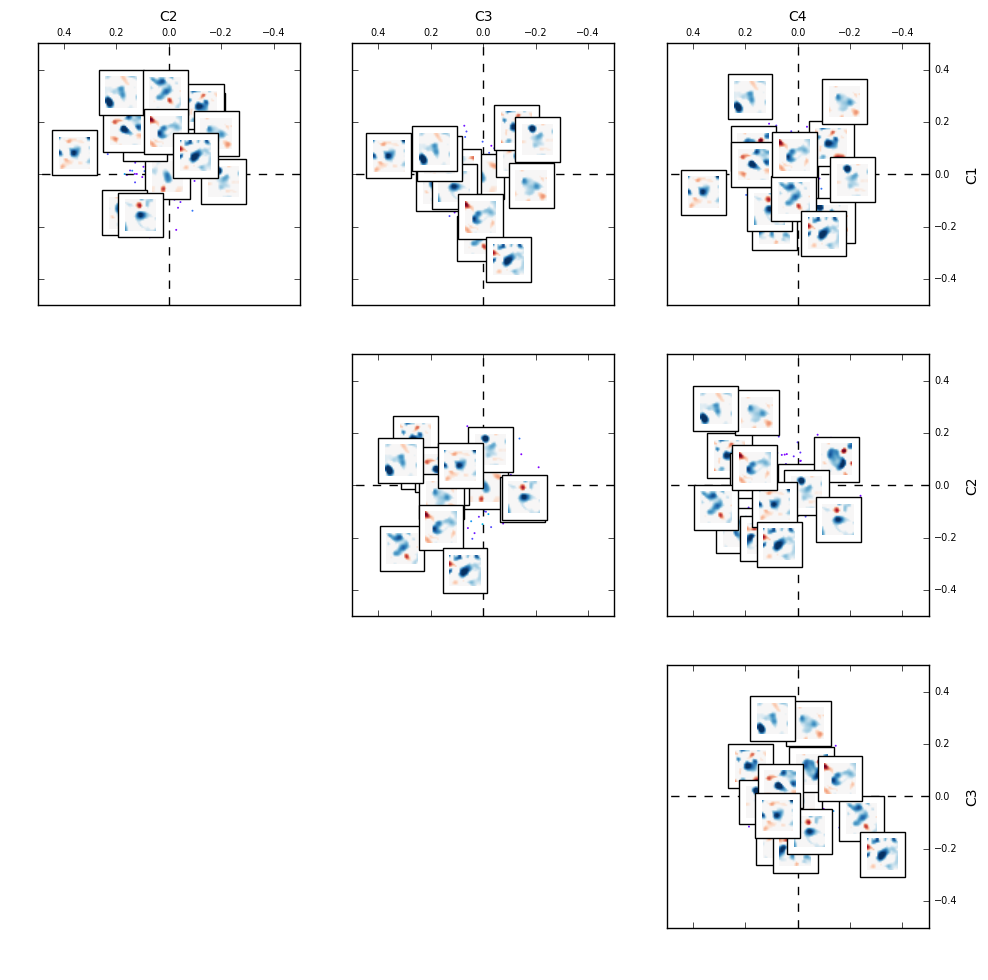

In [21]:
reload(PODutils)
PODutils.plotLLEscatter(outLLEltsa.T,Ypos_Pro,S,list(range(ncomp)),bound=0.5,thumb_frac=0.4,VecDist=0.01)

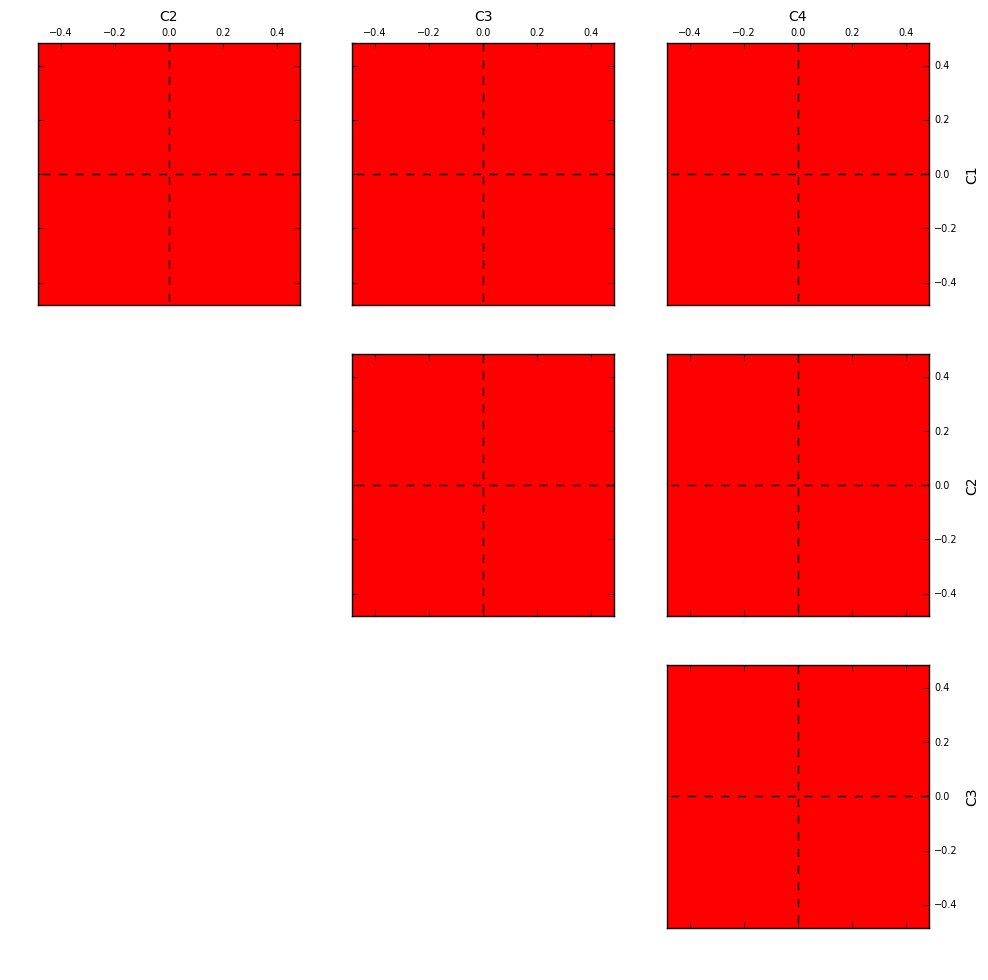

In [22]:
reload(PODutils)
PODutils.plotPODcoeff(outLLEltsa,list(range(ncomp)),100,0.5,1)

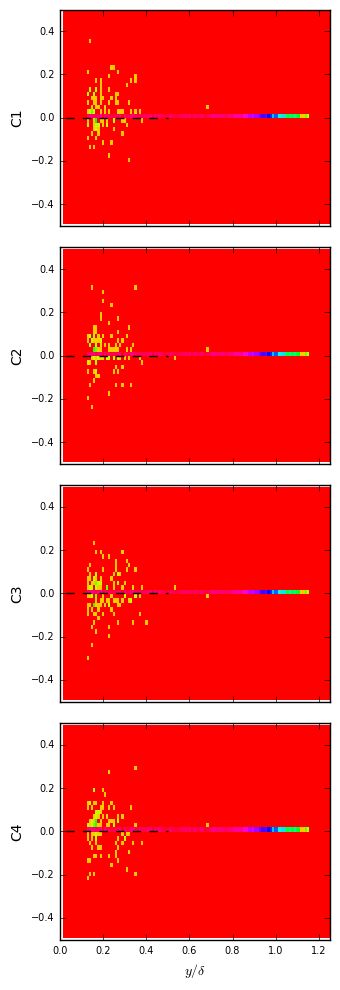

In [24]:
reload(PODutils)
C2 = outLLEltsa.copy()
C2 = np.concatenate([Ypos_Pro.reshape((-1, 1)).T, C2.T], axis=0)
PODutils.plotYposPODcoeff(Yvec,C2,list(range(ncomp)),50,0.5,1)

#### Do Isomap 

In [25]:
from sklearn.manifold import Isomap

t0 = time()
model = Isomap(n_components=ncomp)
outIso = model.fit_transform(uAll)
outIso.shape
print((time() - t0)/60, " mins")

3.4011486331621805  mins


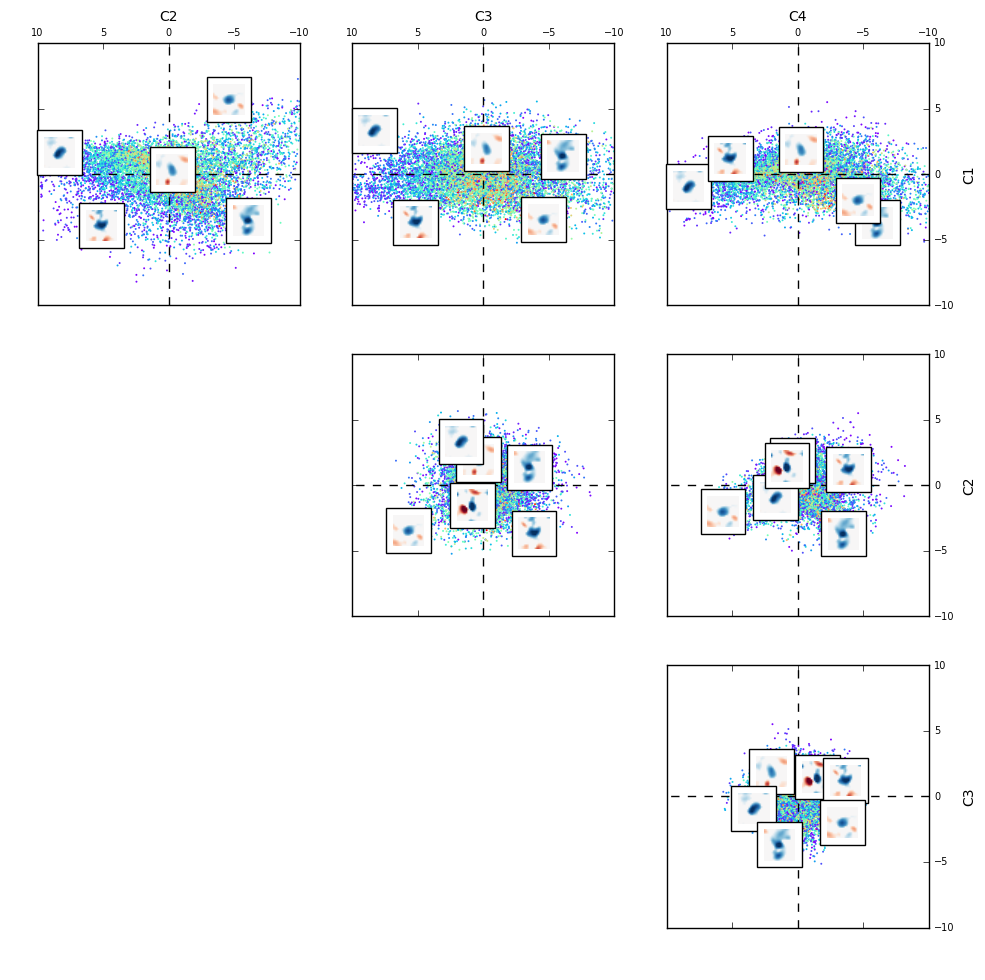

In [26]:
reload(PODutils)
PODutils.plotLLEscatter(outIso.T,Ypos_Pro,S,list(range(ncomp)),bound=10,thumb_frac=0.3,VecDist=0.01)

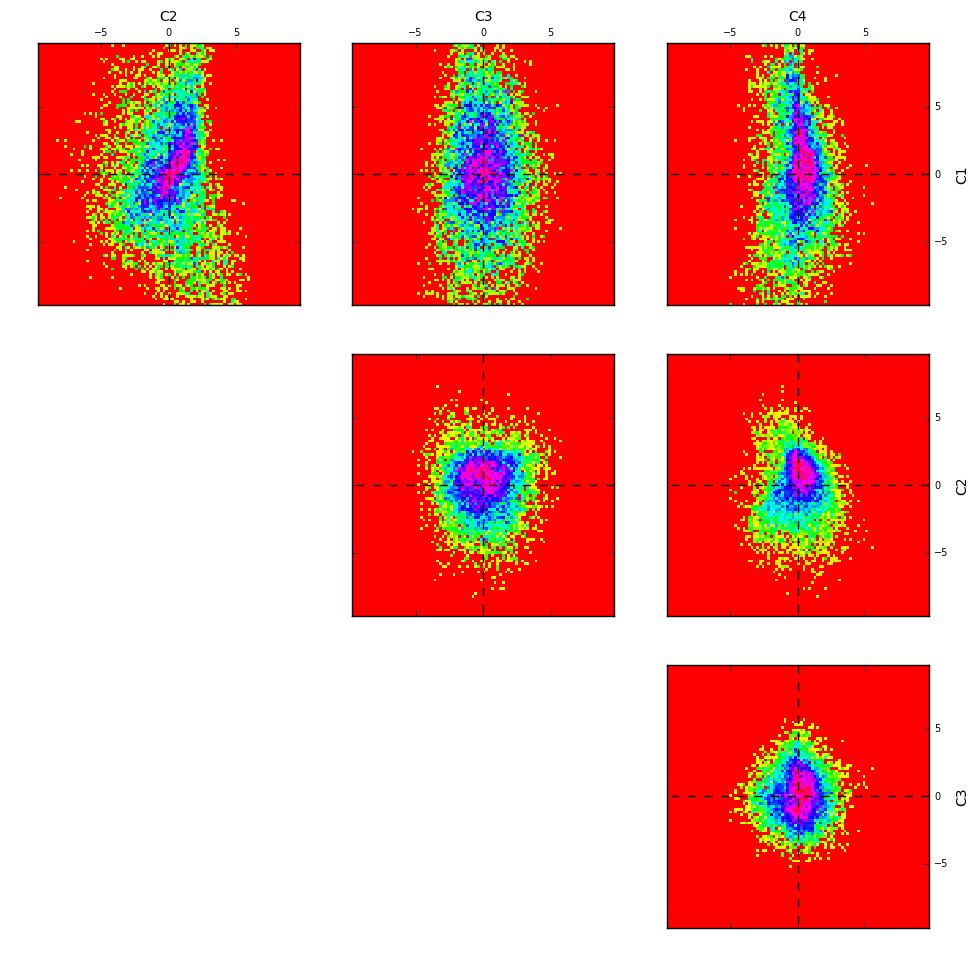

In [27]:
reload(PODutils)
PODutils.plotPODcoeff(outIso.T,list(range(ncomp)),100,10,1)

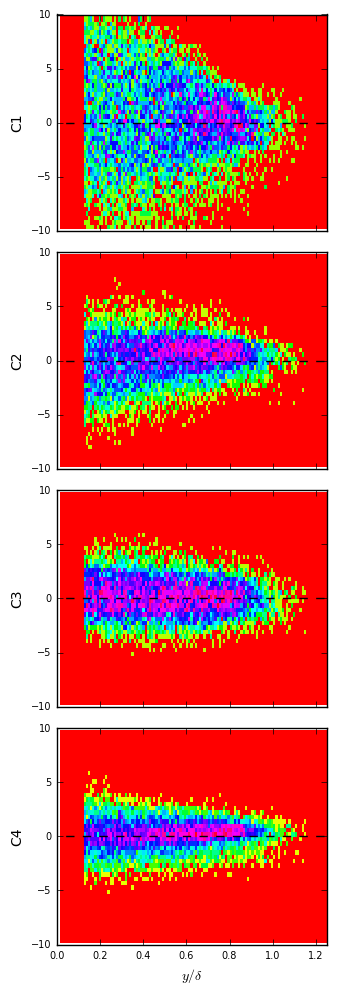

In [28]:
reload(PODutils)
C2 = outIso.copy()
C2 = np.concatenate([Ypos_Pro.reshape((-1, 1)).T, C2.T], axis=0)
PODutils.plotYposPODcoeff(Yvec,C2,list(range(ncomp)),50,10,1)

# Test the result on a randomized sample of the data

In [29]:
X, Y, U, V, Swirl, Cond, Prof = PIVutils.loadDataset(OriginalDataset,\
                                                     ['X','Y','U','V','Swirl'],['Cond','Prof'],matlabData = True)

['#refs#', 'AutoCorr', 'Cond', 'Corr', 'CorrT', 'Err', 'PercentMissing', 'Prof', 'Quad', 'Swirl', 'U', 'V', 'W', 'X', 'Y', 'source']


In [30]:
X = X/Cond["delta"]
Y = Y/Cond["delta"]
uSize = U.shape

In [31]:
#Interpolate missing vectors
for i in range(uSize[2]):
    #print(i)
    f = interpolate.interp2d(X[0,:], Y[:,0], U[:,:,i], kind='linear')
    U[:,:,i] = f(X[0,:],Y[:,0])
    f = interpolate.interp2d(X[0,:], Y[:,0], V[:,:,i], kind='linear')
    V[:,:,i] = f(X[0,:],Y[:,0])   
    f = interpolate.interp2d(X[0,:], Y[:,0], Swirl[:,:,i], kind='linear')
    Swirl[:,:,i] = f(X[0,:],Y[:,0]) 

NameError: name 'interpolate' is not defined

In [ ]:
reload(PIVutils)

Ut, Vt, St = PIVutils.getRandomThumbnails2D(U,V,Swirl,num_features_Pro,BoxSize)

### Now do a range of different manifold learning on the resulting thumbnails

In [ ]:
#Set all NaNs to zero
Ut[np.isnan(Ut)] = 0
Vt[np.isnan(Vt)] = 0

uSize = Ut.shape

In [ ]:
ncomp = 4
nneigh = 50

In [ ]:
uAll = np.concatenate((Ut.reshape(uSize[0]*uSize[1],uSize[2]), Vt.reshape(uSize[0]*uSize[1],uSize[2])), axis = 0).T
#uAll.shape      

#### Do modified LLE

In [ ]:
t0 = time()
model = LocallyLinearEmbedding(n_neighbors=nneigh, n_components=ncomp, method='modified', eigen_solver='dense')
#outLLEmod = model.fit_transform(Ut.reshape(uSize[0]*uSize[1],uSize[2]).T)
outLLEmod = model.fit_transform(uAll)
print((time() - t0)/60, " mins")

In [ ]:
from matplotlib import offsetbox,colors

colorize = dict(c=ypos, cmap=plt.cm.get_cmap('rainbow', 100))
fig, ax = plt.subplots()
h = ax.scatter(outLLEmod[:, 0], outLLEmod[:, 1],s=2, facecolor='0.5', lw = 0, **colorize)
fig.colorbar(h, ax=ax)
plt.axis('scaled')
bound = np.max(np.absolute(outLLEmod))
ax.set_xlim(-1*bound,bound)
ax.set_ylim(-1*bound,bound)

thumb_frac=0.4
cmap='RdBu_r'

min_dist_2 = (thumb_frac * max(outLLEmod.max(0) - outLLEmod.min(0))) ** 2
shown_images = np.array([2 * outLLEmod.max(0)])
for i in range(outLLEmod.shape[0]):
    dist = np.sum((outLLEmod[i] - shown_images) ** 2, 1)
    if np.min(dist) < min_dist_2:
        # don't show points that are too close
        continue
    shown_images = np.vstack([shown_images, outLLEmod[i]])
    
    vecNorm = (outLLEmod[i,0]**2 + outLLEmod[i,1]**2)**0.5
    imagebox = offsetbox.AnnotationBbox(
        offsetbox.OffsetImage(St[:,:,i], cmap=cmap, norm=colors.Normalize(-50,50),zoom=1.5),
                              xybox=0.05*outLLEmod[i,0:2]/vecNorm+outLLEmod[i,0:2],xy=outLLEmod[i,0:2], arrowprops=dict(arrowstyle="->"))
    ax.add_artist(imagebox)
    #imagebox.set_clim([-1*10, 10])

In [ ]:
reload(PODutils)
PODutils.plotLLEscatter(outLLEmod.T,ypos,St,list(range(ncomp)),bound=0.07,thumb_frac=0.4,VecDist=0.01,saveFolder=(saveFolder + '/LLEscatter_mod.tif'))

In [ ]:
reload(PODutils)
PODutils.plotPODcoeff(outLLEmod.T,list(range(ncomp)),100,0.07,1,saveFolder=(saveFolder + '/Coeff_mod.tif'))

In [ ]:
reload(PODutils)
C2 = outLLEmod.copy()
C2 = np.concatenate([ypos.reshape((-1, 1)).T, C2.T], axis=0)
PODutils.plotYposPODcoeff(Y[:,0]/Cond["delta"],C2,list(range(ncomp)),50,0.07,1,saveFolder=(saveFolder + '/YposCoeff_mod.tif'))